In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [21]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data to [0, 1] range
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [22]:
def resnet_block(x, filters, downsample=False):
    shortcut = x
    strides = 2 if downsample else 1

    # First conv layer
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second conv layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut
    if downsample or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add and activate
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [23]:
inputs = layers.Input(shape=(32, 32, 3))

x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)

x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = resnet_block(x, 128, downsample=True)
x = resnet_block(x, 128)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [26]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.3272 - loss: 1.8151 - val_accuracy: 0.2911 - val_loss: 2.1434
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5535 - loss: 1.2476 - val_accuracy: 0.3415 - val_loss: 2.2828
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6319 - loss: 1.0255 - val_accuracy: 0.5349 - val_loss: 1.4496
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6883 - loss: 0.8887 - val_accuracy: 0.5330 - val_loss: 1.5195
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7163 - loss: 0.8083 - val_accuracy: 0.6495 - val_loss: 1.0439
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7528 - loss: 0.7215 - val_accuracy: 0.6221 - val_loss: 1.2179
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7797 - loss: 0.6438 - val_accuracy: 0.7395 - val_loss: 0.7408
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8039 - loss: 0.5770 - 

In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7925 - loss: 0.8337
Test accuracy: 0.79


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


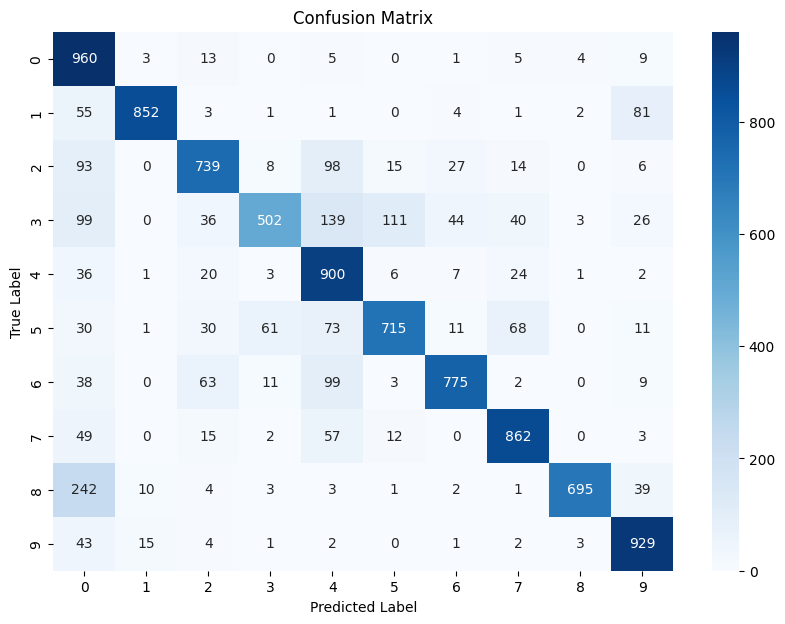

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Get true class labels from y_test
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

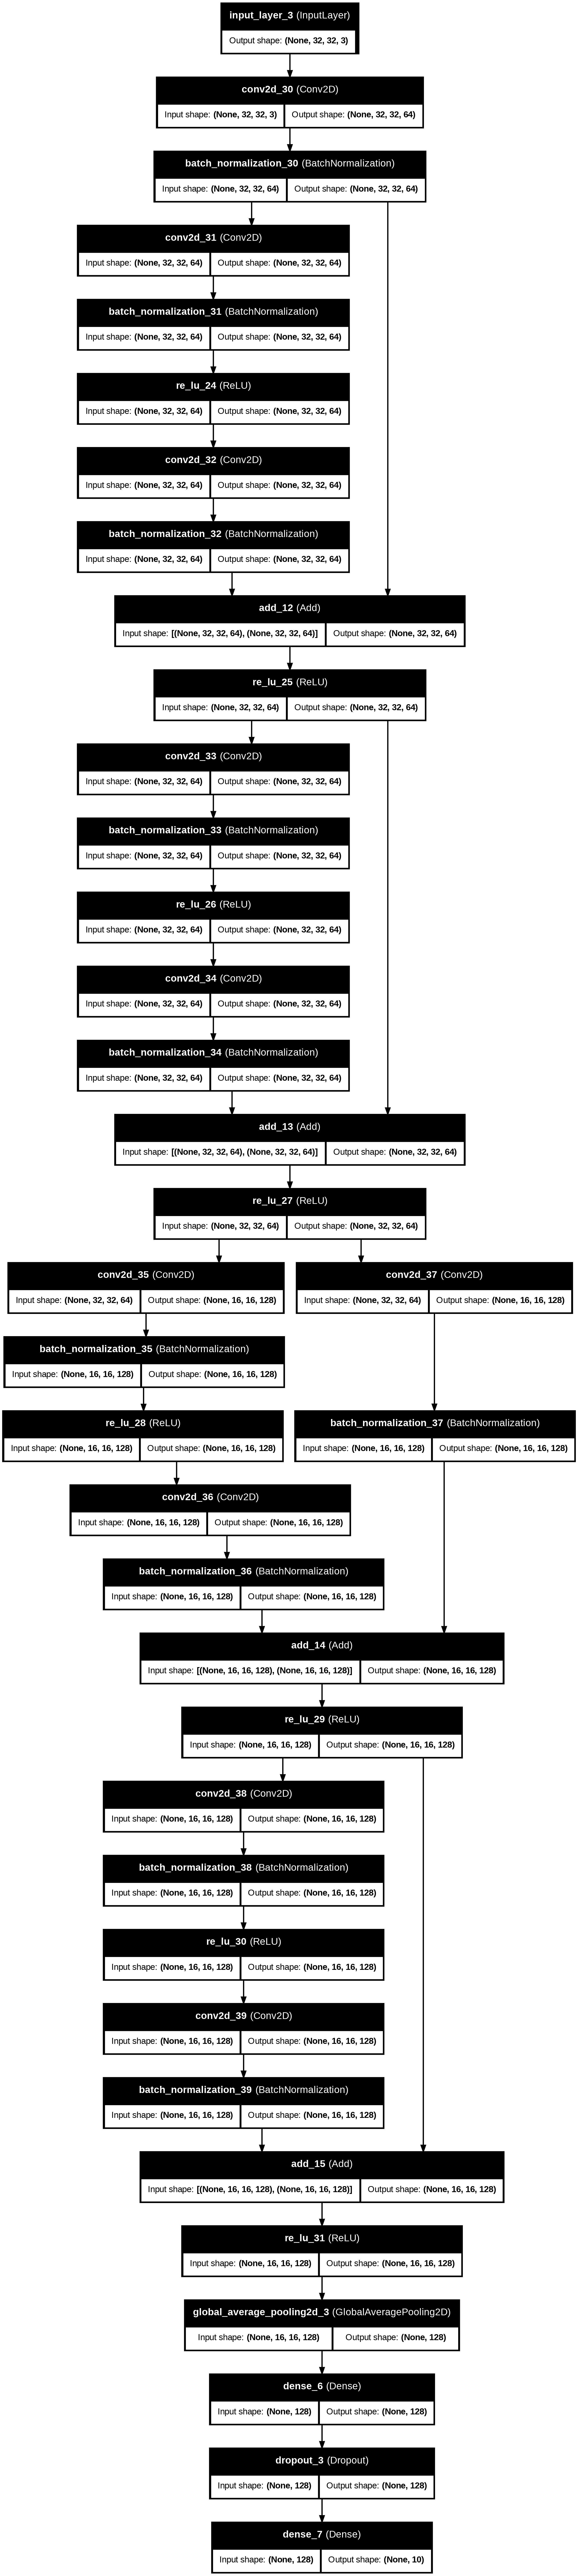

In [30]:
# Install required libraries for generating and displaying model architecture diagrams
!pip install pydot graphviz

from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Assuming `model` is your model object
# Generate and save the model architecture diagram
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture diagram inline (for Jupyter Notebooks)
Image('model_architecture.png')

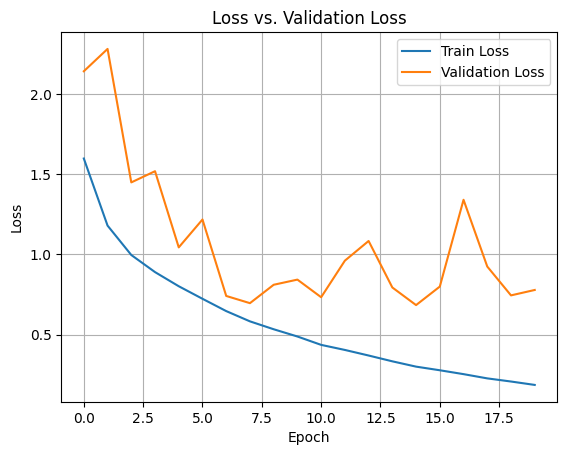

In [31]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


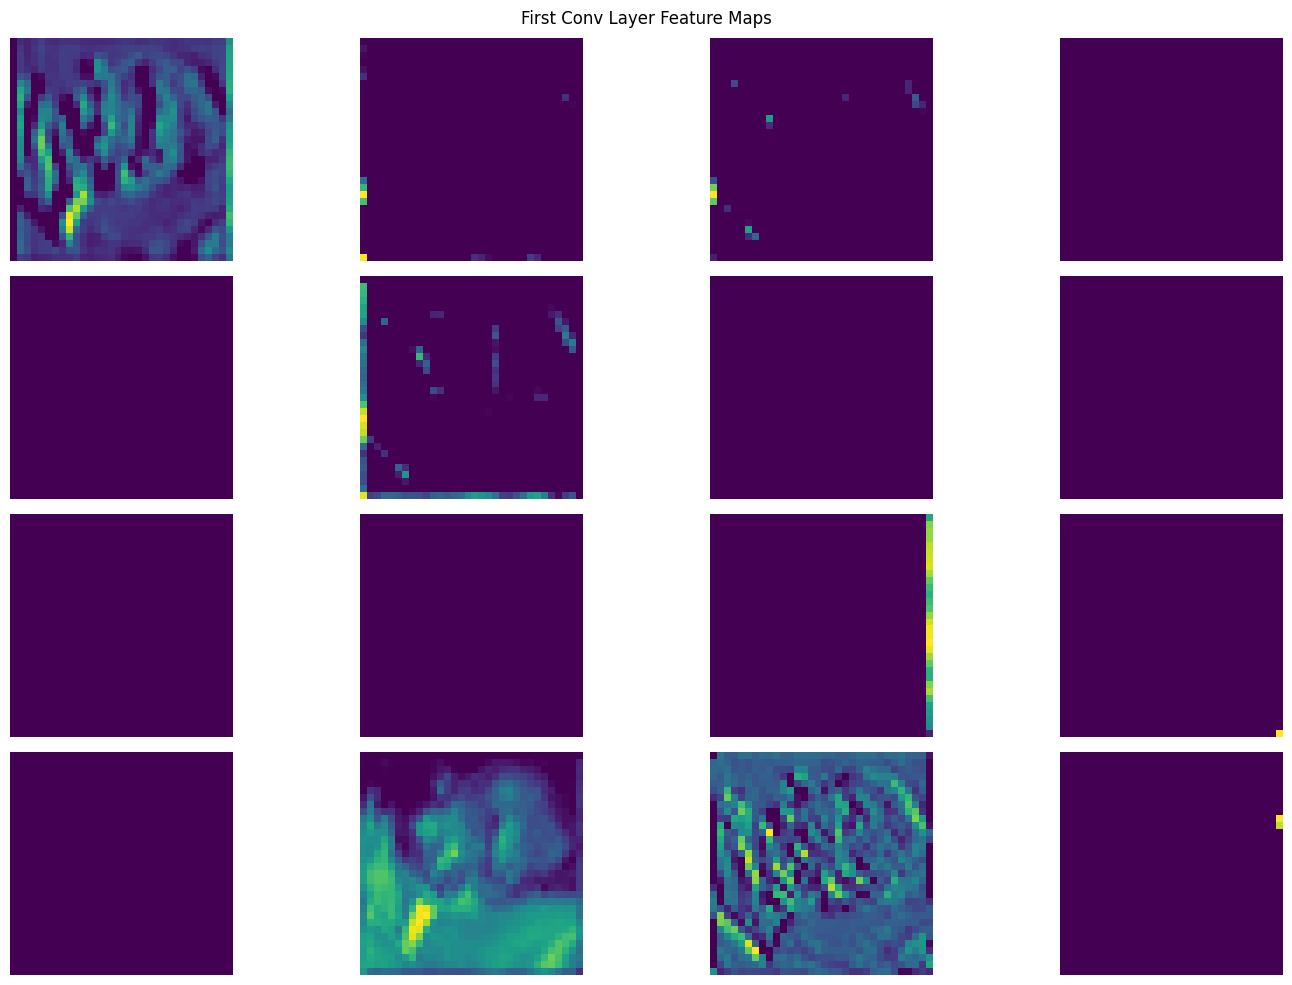

In [32]:
from tensorflow.keras.models import Model

layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

img = x_test[0].reshape(1, 32, 32, 3)
activations = activation_model.predict(img)

# Plot first conv layer activations
plt.figure(figsize=(15, 10))
for i in range(16):  # First 16 filters
    plt.subplot(4, 4, i+1)
    plt.imshow(activations[0][0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('First Conv Layer Feature Maps')
plt.tight_layout()
plt.show()